# Explainability Self-Study Exercise

Author: Nina Nowak, Senior Data Scientist at <a href="http://themix.ai/">Combient Mix</a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In this notebook we will try to explain the output of a simple classification model using the Python modules LIME and SHAP. You do not need to know how to build machine learning models, but to do the exercise segments you will need some basic knowledge of Python.

To run a cell: press SHIFT+ENTER

Let's start and first install and import some python modules

In [ ]:
!pip install lime
!pip install shap

In [2]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import io

## 1a) Load and inspect the Wine Quality dataset

We use the Wine Quality Dataset https://archive.ics.uci.edu/ml/datasets/wine+quality

In [3]:
wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',sep=';')
#wine = pd.read_csv('winequality-red.csv', sep=';')
wine.head()

fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.4              0.70         0.00  ...       0.56      9.4        5
1            7.8              0.88         0.00  ...       0.68      9.8        5
2            7.8              0.76         0.04  ...       0.65      9.8        5
3           11.2              0.28         0.56  ...       0.58      9.8        6
4            7.4              0.70         0.00  ...       0.56      9.4        5

[5 rows x 12 columns]

In [4]:
# How many observations?
len(wine)

1599

In [5]:
# basic statistics of each feature
wine.describe()

fixed acidity  volatile acidity  ...      alcohol      quality
count    1599.000000       1599.000000  ...  1599.000000  1599.000000
mean        8.319637          0.527821  ...    10.422983     5.636023
std         1.741096          0.179060  ...     1.065668     0.807569
min         4.600000          0.120000  ...     8.400000     3.000000
25%         7.100000          0.390000  ...     9.500000     5.000000
50%         7.900000          0.520000  ...    10.200000     6.000000
75%         9.200000          0.640000  ...    11.100000     6.000000
max        15.900000          1.580000  ...    14.900000     8.000000

[8 rows x 12 columns]

In [6]:
# How many wines are in each quality class?
wine.groupby('quality')['quality'].count()

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

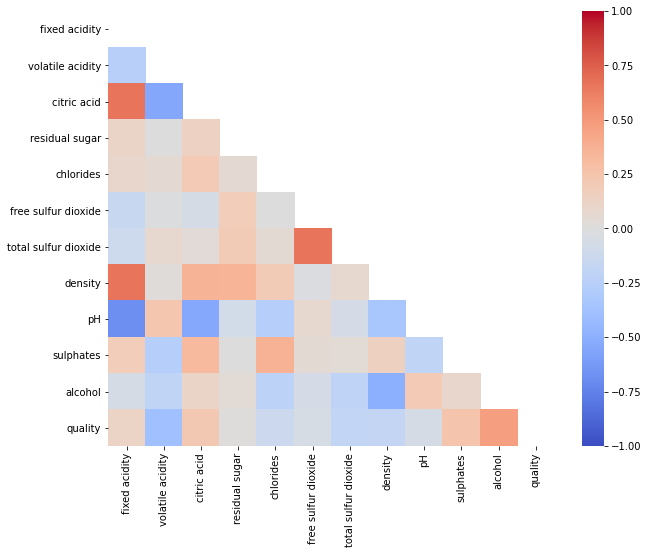

In [7]:
# Are there any correlations?
plt.figure(figsize=(10, 8))
matrix = np.triu(wine.corr())
sns.heatmap(wine.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)

## 1b) Modelling

In [8]:
# Choose a target variable for prediction: quality
# To simplify the problem, we create a binary target: divide into good (1) and bad (0) wine. Good wine has quality >=6.
wine['quality_score'] = [1 if x>=6 else 0 for x in wine.quality]
wine.groupby('quality_score')['quality_score'].count() # the two classes are approximately balanced

quality_score
0    744
1    855
Name: quality_score, dtype: int64

In [9]:
# prepare data for modelling
X = wine.drop('quality',axis=1)
X = X.drop('quality_score',axis=1)
y_label = wine.quality_score
X_index = wine.index
feature_names = X.columns

In [10]:
# split data into train and test set
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y_label, test_size=0.2, random_state=42)


In [11]:
# choose a random forest classifier to predict whether a wine is of good or bad quality
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [12]:
# Model Accuracy, how often is the classifier correct?
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.790625


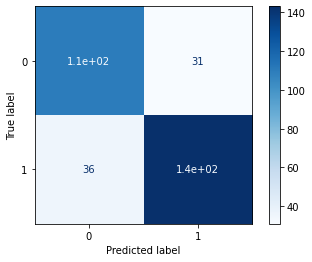

In [13]:
# confusion matrix
#metrics.confusion_matrix(y_test,y_pred)
metrics.plot_confusion_matrix(clf, X_test, y_test, display_labels=[0,1],
                                 cmap=plt.cm.Blues)
plt.grid(False)

In [14]:
# Feature importance (table)
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

alcohol                 0.190531
sulphates               0.138620
total sulfur dioxide    0.099428
volatile acidity        0.097729
density                 0.088862
chlorides               0.072550
citric acid             0.066797
fixed acidity           0.065742
pH                      0.064648
free sulfur dioxide     0.059281
residual sugar          0.055811
dtype: float64

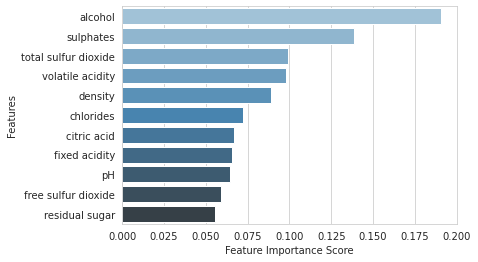

In [15]:
# Feature importance (bar plot)
sns.set_style("whitegrid")
sns.barplot(x=feature_imp, y=feature_imp.index, palette="Blues_d")
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
#plt.legend()
plt.show()


## 1c) Explanation with LIME

We would like to find out why a specific wine is classified as good or bad by the model. How does each feature contribute to the decision?

In [16]:
from lime import lime_tabular

We pick a random observation from the test set and explain the prediction for this particular observation using LIME.

In [17]:
# Run this cell several times to see the explanations for several observations
i = np.random.randint(0, X_test.shape[0])

print("probilities for ['bad','good']:", clf.predict_proba(X_test)[i])
print("True quality:", 'good' if y_test.iloc[i]==1 else 'bad')
print("Predicted quality:", 'good' if clf.predict(X_test)[i]==1 else 'bad')

lime_explainer = lime_tabular.LimeTabularExplainer(np.array(X_train),
                    feature_names=feature_names, 
                    class_names=['bad','good'], 
                    # categorical_features=, 
                    # There is no categorical features in this example, otherwise specify them.                               
                    verbose=False, mode='classification')

exp = lime_explainer.explain_instance(X_test.iloc[i], clf.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

probilities for ['bad','good']: [0.21 0.79]
True quality: good
Predicted quality: good


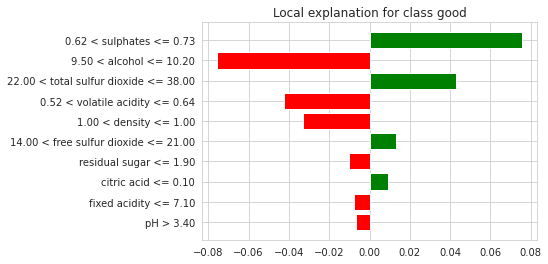

In [18]:
# Plot of weighted features
exp.as_pyplot_figure();

## 1d) Explanation with SHAP

In the previous section we used LIME to explain single observations, and we could see how much each feature contributed to the decision. Now we will use Shapley values. They provide more flexibility when it comes to analysis and visualisation.

In [19]:
import shap

### Individual explanations

In [20]:
# Explanation of a single instance
#i = np.random.randint(0, X_test.shape[0])  #comment if you want to use the same instance as above for Lime

shap_explainer = shap.TreeExplainer(clf)
shap_values = shap_explainer.shap_values(X_test)
shap.initjs()
shap.force_plot(shap_explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[[i]])

- The output value (bold black number, f(x)) is the prediction for that observation (>0.5: good wine)
- Blue: pushes the prediction to lower values, Red: pushes the prediction to higher values
- The base value is the mean prediction for class 1 (good wine), for the entire test set

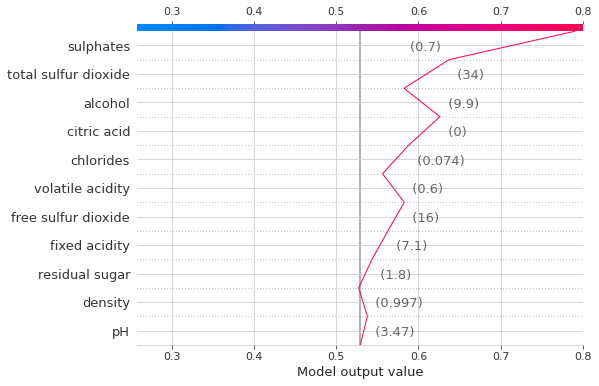

In [21]:
# Decision plot for a single instance
shap.decision_plot(shap_explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[[i]])


### Many observations

In [22]:
# Visualisation of many explanations: force plot
shap.initjs()
shap.force_plot(shap_explainer.expected_value[1], shap_values[1][:200,:], X_test.iloc[:200,:])

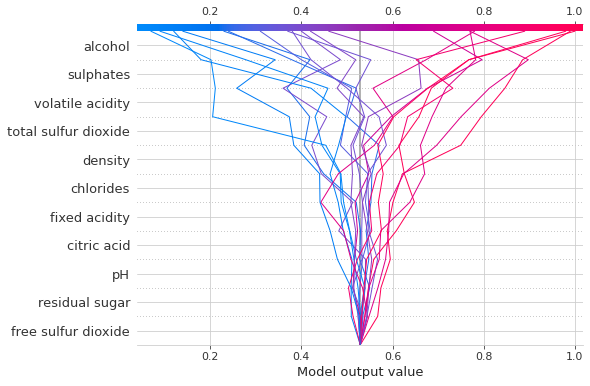

In [23]:
# Decision plot for the first 20 instances
shap.decision_plot(shap_explainer.expected_value[1], shap_values[1][:20,:], X_test.iloc[:20,:])


In [ ]:
# Look at 
# - true positives
# - false positives 
# - true negatives
# - false negatives
# and compare them using decision plots and force plots.

# Select the true positives
# your code here

# Select the false positives
# your code here

# Select the true negatives
# your code here

# Select the false negatives
# your code here

In [ ]:
#@title Run this cell to see a solution { vertical-output: true, display-mode: "form" }
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()

        display(Markdown("""``` 
# True positives
tp_shap = shap_values[1][(y_test==1) & (clf.predict(X_test)==1)]
tp_X = X_test[(y_test==1) & (clf.predict(X_test)==1)]

# False positives
fp_shap = shap_values[1][(y_test==0) & (clf.predict(X_test)==1)]
fp_X = X_test[(y_test==0) & (clf.predict(X_test)==1)]

# True negatives
tn_shap = shap_values[1][(y_test==0) & (clf.predict(X_test)==0)]
tn_X = X_test[(y_test==0) & (clf.predict(X_test)==0)]

# False negatives
fn_shap = shap_values[1][(y_test==1) & (clf.predict(X_test)==0)]
fn_X = X_test[(y_test==1) & (clf.predict(X_test)==0)]
```"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

In [ ]:
# True positives
tp_shap = shap_values[1][(y_test==1) & (clf.predict(X_test)==1)]
tp_X = X_test[(y_test==1) & (clf.predict(X_test)==1)]

# False positives
fp_shap = shap_values[1][(y_test==0) & (clf.predict(X_test)==1)]
fp_X = X_test[(y_test==0) & (clf.predict(X_test)==1)]

# True negatives
tn_shap = shap_values[1][(y_test==0) & (clf.predict(X_test)==0)]
tn_X = X_test[(y_test==0) & (clf.predict(X_test)==0)]

# False negatives
fn_shap = shap_values[1][(y_test==1) & (clf.predict(X_test)==0)]
fn_X = X_test[(y_test==1) & (clf.predict(X_test)==0)]

In [ ]:
# Make a decision plot for the true positives:

# your code here

In [24]:
#@title Run this cell to see a solution { display-mode: "form" }
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()

        display(Markdown("""``` 
shap.decision_plot(shap_explainer.expected_value[1], tp_shap, tp_X)
```"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

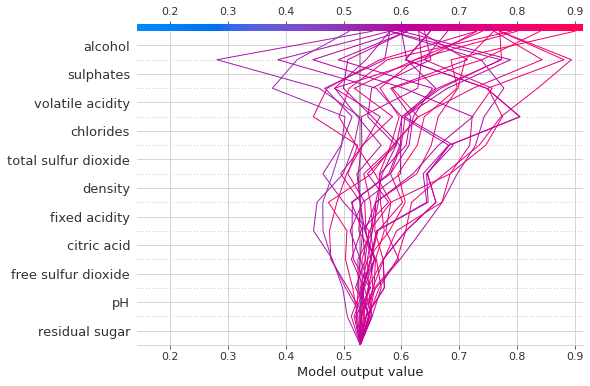

In [ ]:
# Make a decision plot for the false positives

# your code here
shap.decision_plot(shap_explainer.expected_value[1], fp_shap, fp_X)

In [ ]:
#@title Run this cell to see a solution { vertical-output: true, display-mode: "form" }
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()

        display(Markdown("""``` 
shap.decision_plot(shap_explainer.expected_value[1], fp_shap, fp_X)```"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

In [ ]:
# Make a decision plot for the true negatives

# your code here


In [ ]:
#@title Run this cell to see a solution { vertical-output: true, display-mode: "form" }
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()

        display(Markdown("""``` 
shap.decision_plot(shap_explainer.expected_value[1], tn_shap, tn_X)```"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

In [ ]:
# Make a decision plot for the false negatives

# your code here


In [ ]:
#@title Run this cell to see a solution { vertical-output: true, display-mode: "form" }
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()

        display(Markdown("""``` 
shap.decision_plot(shap_explainer.expected_value[1], fn_shap, fn_X)
```"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

In [ ]:
# Use force_plot and look at the true/false positives/negatives
# Play around and change the x and y-axes
shap.initjs()
shap.force_plot(shap_explainer.expected_value[1], fp_shap, fp_X)

### Global interpretability

#### 1. Feature importance

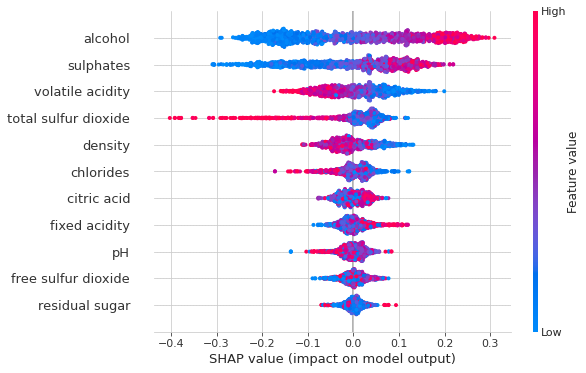

In [ ]:
shap_values = shap.TreeExplainer(clf).shap_values(X)
shap.summary_plot(shap_values[1], X, plot_type="dot")

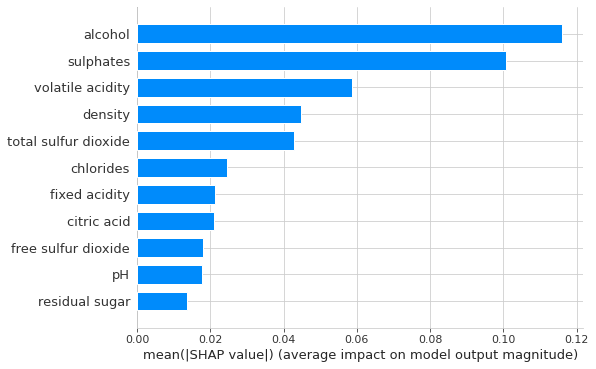

In [ ]:
# try different plot_types: bar and violin
# Solution 1:
shap.summary_plot(shap_values[1], X, plot_type="bar")

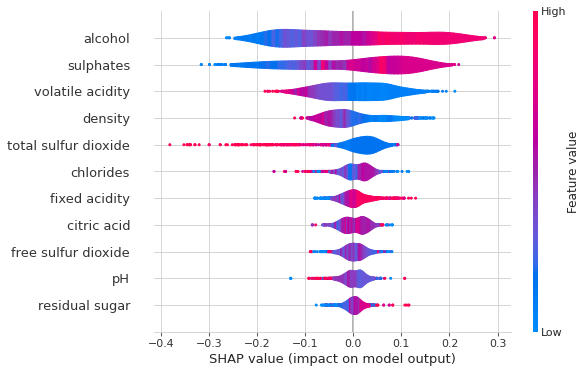

In [ ]:
# Solution 2:
shap.summary_plot(shap_values[1], X, plot_type="violin")

#### 2. Dependence Plots

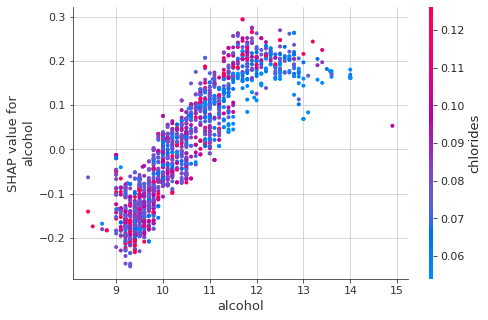

In [ ]:
# SHAP dependence plots show the marginal effect one or two features have on the predicted outcome of a machine learning model. 
# They plot the values of one feature vs. the SHAP values of that feature. Dependens plots tell whether the relationship between
# the target and a feature is linear, monotonic or more complex.

# The following plot shows there is an approximately linear and positive trend between “alcohol” and the target variable, 
# and “alcohol” interacts with “volatile acidity” frequently.
shap.dependence_plot('alcohol', shap_values[1], X)

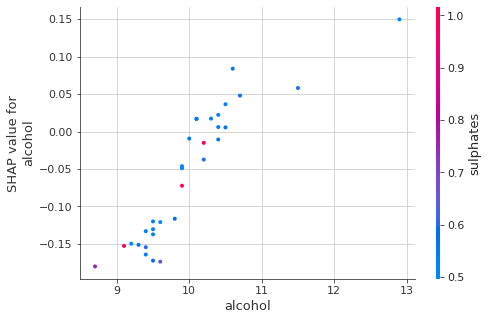

In [ ]:
# How does it look like for subsamples, e.g. false negatives?

# Solution:
shap.dependence_plot('alcohol', fn_shap, fn_X)

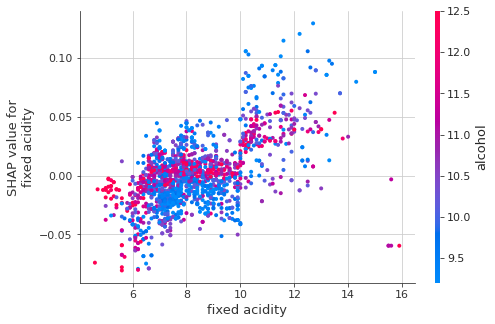

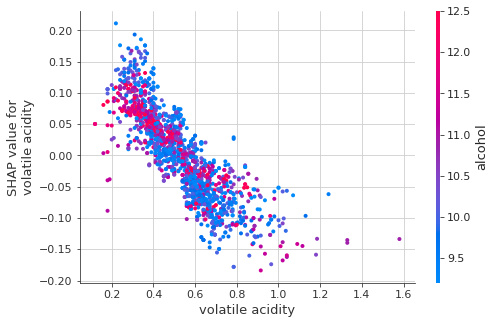

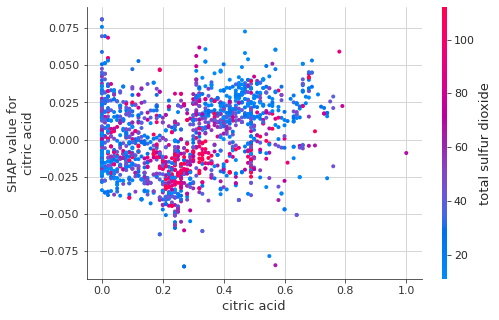

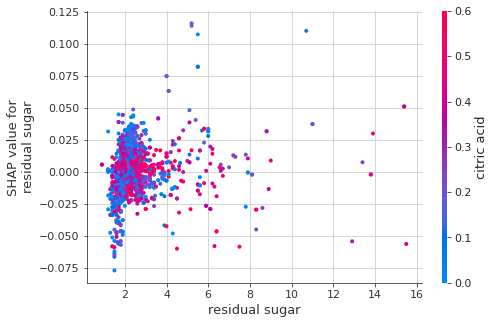

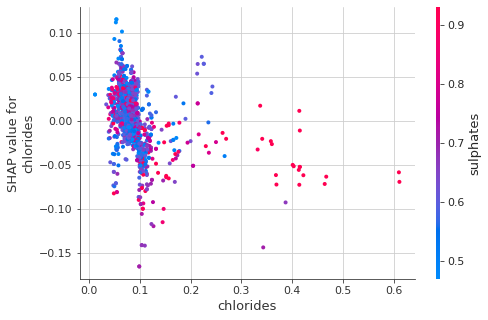

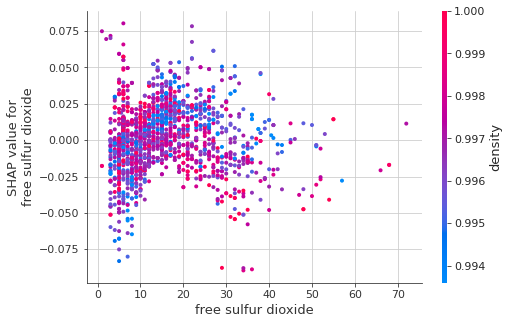

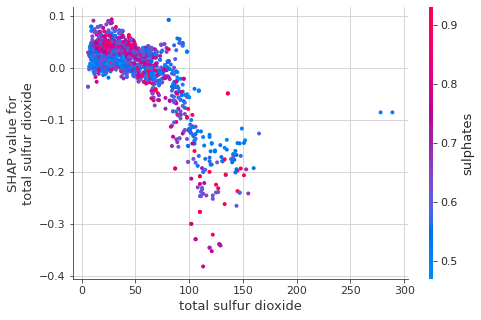

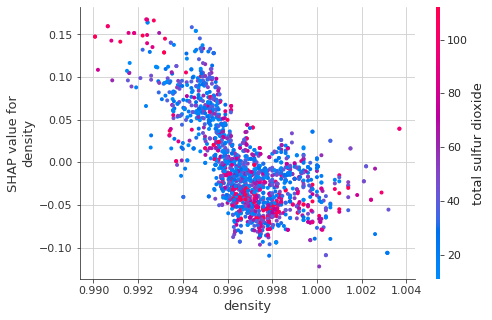

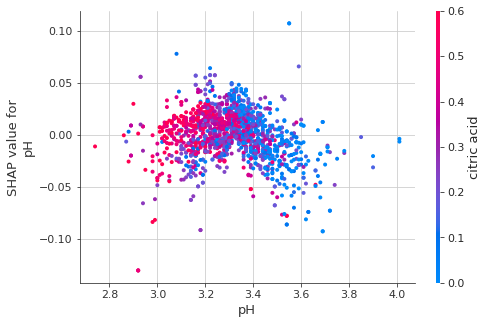

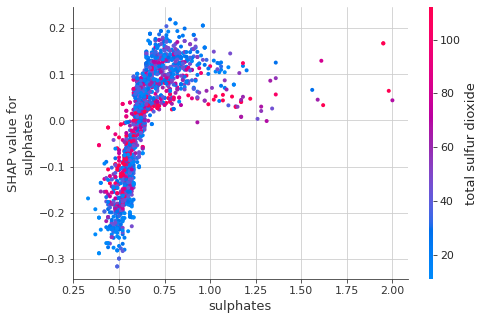

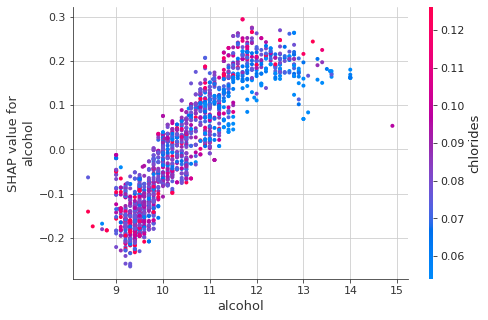

In [ ]:
# Can you find other depencencies between features and the target variable?

# Solution:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X)


# 2) Train what you learned above with a new dataset
## 2a) Load and inspect the Adult dataset

The Adult Income dataset is from the 1994 United States Census Bureau. The task is to predict whether a given individual makes more than $50,000 a year based attributes such as education, hours of work per week, etc.

In [1]:
# We use the Adult Income Dataset http://archive.ics.uci.edu/ml/datasets/Adult
adult = pd.read_csv('https://github.com/nillepu/EthicalAI/raw/main/adult-all.csv',sep=',')
adult.head()

NameError: ignored

In [2]:
# How many observations?
len(adult)

NameError: ignored

In [ ]:
# basic statistics of each feature
adult.describe()

In [ ]:
# predict the income using a simple random forest algorithm

cat_features = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']

# Choose a target variable for prediction: class
# To simplify the problem, we create a binary target: divide into good (1) and bad (0) wine. Good wine has quality >=6.
adult['income_cat'] = [1 if x=='>50K' else 0 for x in adult['income']]

# prepare data for modelling
X = adult.drop('income',axis=1)
X = X.drop('income_cat',axis=1)
y_label = adult.income_cat
X_index = adult.index
feature_names = X.columns

# encode the categorical features
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for name in cat_features:
    X[name] = le.fit_transform(X[name])

# split data into train and test set
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y_label, test_size=0.2, random_state=42)

# choose a random forest classifier to predict whether a wine is of good or bad quality
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(class_weight="balanced")
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

## 2b) Explanation with LIME

In [ ]:
from lime import lime_tabular

In [ ]:
# Pick a random observation from the test set and explain the prediction for this particular observation
# Run this several times to see the explanations for several observations
# Use 1c) as an example

# Solution:
i = np.random.randint(0, X_test.shape[0])

print("probilities for ['<=50K','>50K']:", clf.predict_proba(X_test)[i])
print("True income:", '>50K' if y_test.iloc[i]==1 else '<=50K')
print("Predicted income:", '>50K' if clf.predict(X_test)[i]==1 else '<=50K')

lime_explainer = lime_tabular.LimeTabularExplainer(np.array(X_train),
                    feature_names=feature_names, 
                    class_names=['<=50K','>50K'], 
                    categorical_features=cat_features, 
                    verbose=False, mode='classification')

exp = lime_explainer.explain_instance(X_test.iloc[i], clf.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# Plot of weighted features
exp.as_pyplot_figure();